In [1]:
import numpy as np
from catan import Catan, CatanException, get_random_dice_arrangement, Player, simulate_game, simulate_game_and_save
import matplotlib.pyplot as plt
from itertools import repeat
%matplotlib inline

In [34]:
class Goal:
    def __init__(self, tasks=[], x=-1, y=-1):
        self.tasks = list(tasks)
        self.x, self.y = x, y

class CityGoal(Goal):
    def estimate_weight(self, player, htime):
        return 1 / (0.1+htime) # TODO

class SettlementGoal(Goal):
    def estimate_weight(self, player, htime):
        return 10 / (0.1+htime) # TODO

class PortGoal(SettlementGoal):
    def estimate_weight(self, player, htime):
        return 2 / (0.1+htime) # TODO

class CardGoal(Goal):
    def estimate_weight(self, player, htime):
        return 0.2 # TODO


class Task:
    def __init__(self, x=-1, y=-1):
        self.x, self.y = x, y
    
    def make_trading_rule(self, player):
        return lambda x,y,z: (x,y,z)  # TODO
    
    def execute(self, player):
        pass

class CardTask(Task):
    resources_needed = (1, 2, 2)
    def execute(self, player):
        if player.if_can_buy("card"):
            player.buy("card")
            return True
        return False

class CityTask(Task):
    resources_needed = (0, 3, 3)
    def execute(self, player):
        if player.if_can_buy("city"):
            print(player.resources)
            print("building city!")
            player.buy("city", self.x, self.y)
            print(player.resources)
            player.available_locations.add((self.x, self.y))
            return True
        return False

class SettlementTask(Task):
    resources_needed = (2, 1, 1)
    def execute(self, player):
        if player.if_can_buy("settlement"):
            print(player.resources)
            print("building settlement at %d %d!" % (self.x, self.y))
            player.buy("settlement", self.x, self.y)
            print(player.resources)
            player.available_locations.add((self.x, self.y))
            return True
        return False

class RoadTask(Task):
    resources_needed = (1, 1, 0)
    def execute(self, player):
        if player.if_can_buy("road"):
            print("building road from !", self.x, self.y)
            player.buy("road", self.x, self.y)
            player.available_locations.add(self.x)
            player.available_locations.add(self.y)
            return True
        return False


In [ ]:
# this is a function pretty much copied from catan.py
# self here must be the board
def if_can_build_noroads(self, building, x, y): 
        """returns true if spot (x,y) is available, false otherwise"""
        if x< 0 or y<0 or x > self.width+1 or y > self.height + 1:
            raise CatanException("({0},{1}) is an invalid vertex".format(x,y))
        #first let's check that the spot is empty:
        if self.get_vertex_number(x,y) in self.cities or self.get_vertex_number(x,y) in self.settlements:
            return False

        ## upgrading first settlment into a city
        if (building == "city"):
            return self.get_vertex_number(x, y) in self.settlements

        ## If no cities, or settlements, build for freebies, otherwise need road connecting.
        for x1 in range(x-1,x+2):
            for y1 in range(y-1,y+2):
                if x1+y1 < x+y-1 or x1+y1 > x+y+1 or y1-x1 < y-x-1 or y1-x1 > y-x+1: ## only interested in up, down, left, and right
                    pass
                elif x1 < 0 or x1 > self.width or y1 < 0 or y1 > self.height: ## only interested in valid tiles
                    pass
                elif self.get_vertex_number(x1, y1) in self.settlements or self.get_vertex_number(x1, y1) in self.cities:
                    return False
        return True



In [30]:
def encode_loc(x, y):
    return y * 5 + x

def decode_loc(i):
    return i % 5, i // 5

def hitting_time_for_a_road(player, roadTask):
    w, b, g = (1, 1, 0)
    trade_rule = roadTask.make_trading_rule(player)
    resources_per_roll = player.board.get_resources()
    P = transition_matrix(resources_per_roll, trade_rule)
    indexes, beta = hitting_time(P, w, b, g)
    return beta[0] # time from no resources

MEMO = {}
CURRENT = -1
def hitting_time_until_task(player, task):
    global CURRENT, MEMO
    turn_num = player.turn_counter
    if CURRENT != turn_num:
        CURRENT = turn_num
        MEMO = {}
    if type(task) in MEMO:
        return MEMO[type(task)]
    
    if isinstance(task, RoadTask):
        MEMO[type(task)] = hitting_time_for_a_road(player, task)
        return MEMO[type(task)]
    
    w, b, g = task.resources_needed
    w_curr, b_curr, g_curr = player.resources
    if w_curr >= w and b_curr >= b and g_curr >=g:
        return 0
    trade_rule = task.make_trading_rule(player)
    resources_per_roll = player.board.get_resources()
    P = transition_matrix(resources_per_roll, trade_rule)
    indexes, beta = hitting_time(P, w, b, g)
    encoded = int(encode(w_curr, b_curr, g_curr))
    i = indexes.index(encoded)
    MEMO[type(task)] = beta[i]
    return MEMO[type(task)]

def calculate_hitting_time(player, goal):
    return sum(hitting_time_until_task(player, task) for task in goal.tasks)

def choose_goal_to_pursue(player, goals):
    weights = []
    for goal in goals:
        time_to_goal = calculate_hitting_time(player, goal)
        weight = goal.estimate_weight(player, time_to_goal)
        weights.append(weight)
    return goals[np.argmax(weights)]

def distance(loc1, loc2):
    return abs(loc1[0] - loc2[0]) + abs(loc1[1] - loc2[1])

def get_shortest_path_to_location(available_locations, x, y):
    """ Returns a list of ((x1, y1), (x2, y2)) tuples, each symbolizing a road to be built"""
    # this is the closest point to the destination (x, y)
    start = min(available_locations, key=lambda loc: distance(loc, (x, y)))
    # right now we assume that the best path to take is by going diagonally across the board
    #     that way we maximize new available locations that have 4 neighboring resources
    #     maybe ideally it would take into account where the other roads are and build in an opposite direction to them or smth
    amount_to_go = [x - start[0], y - start[1]] # (amount_to_go_right, amount_to_go_up)
    points_to_hit = [start]
    curr = list(start) # so that it is mutable, will need to cast to tuple before recording
    end  = [x, y]
    while curr != end:
        # if i == 0, we are moving left/right, if i == 1, we are moving down/up
        # this will move horizontally, then diagonally
        i = 0 if abs(amount_to_go[0]) >= abs(amount_to_go[1]) else 1
        amount = amount_to_go[i] // abs(amount_to_go[i])
        curr[i] += amount
        amount_to_go[i] -= amount
        points_to_hit.append(tuple(curr))
    # Now points_to_hit is populated with (x,y) tuples of all the locations we're going to hit
    return list(zip(points_to_hit, points_to_hit[1:]))

def generate_road_tasks_to_point(player, x, y):
    """If all building/road buys were made through the Task API, then 
            available_locations is a set of (x,y) tuples with points we can build roads from"""
    cheapest_roads_to_get_there = get_shortest_path_to_location(player.available_locations, x, y)
    tasks = []
    for road in cheapest_roads_to_get_there:
        tasks.append(RoadTask(road[0], road[1]))
    return tasks

def generate_settlement_goal_at_location(player, x, y):
    tasks = generate_road_tasks_to_point(player, x, y)
    tasks.append(SettlementTask(x, y))
    return SettlementGoal(tasks, x, y)

def generate_port_goal_at_location(player, x, y):
    tasks = generate_road_tasks_to_point(player, x, y)
    tasks.append(SettlementTask(x, y))
    return PortGoal(tasks, x, y)

def generate_all_settlement_port_goals(player):
    stlments = set(player.board.settlements)
    cities = set(player.board.cities)
    # all possible places to place new settlements
    possible = set((x,y) 
                for x in range(5) for y in range(5)
                if if_can_build_noroads(player.board, "settlement", x, y))
    ports = set([(0,0), (0,4), (4,0), (4,4)])
    goals = []
    for x, y in possible:
        if (x,y) in ports:
            goals.append(generate_port_goal_at_location(player,x,y))
        else:
            goals.append(generate_settlement_goal_at_location(player,x,y))
    return goals

def generate_all_city_goals(player):
    goals = []
    all_settlements = player.board.settlements
    for x, y in map(decode_loc, all_settlements):
        task = CityTask(x, y)
        goals.append(CityGoal([task], x, y))
    return goals

def generate_all_possible_goals(player):
    # Add all the possible settlment only goals (no building of roads)
    settlements = generate_all_settlement_port_goals(player)
    # Add all the possible city goals
    cities = generate_all_city_goals(player)
    # Add all the card goal
    cards = [
        CardGoal([CardTask()])
    ]
    return settlements + cards + cities

def action(self):
    if self.turn_counter == 0:
        # What are we to do on our first turn?
        x, y = self.preComp
        self.available_locations = set()
        settlementTask = SettlementTask(x, y)
        settlementTask.execute(self)
        # initialize some values
        self.turns_to_recompute = 0
    
    if self.turns_to_recompute <= 0:
        # Let us compute our current goal
        possible_goals = generate_all_possible_goals(self)
        self.current_goal = choose_goal_to_pursue(self, possible_goals)
        self.turns_to_recompute = 5
    
    tasks = self.current_goal.tasks
    while len(tasks) > 0:
        curr_task = tasks[0]
        if curr_task.execute(self):
            tasks.pop(0)
        else:
            break # Could not complete our task for some reason
    self.turns_to_recompute -= 1

def average_resources_per_turn(board, locations):
    DICE_ROLL_PROBS = 1/36 * np.array([1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1])
    r = [0,0,0]
    for x, y in locations:
        for dx in [-1, 0]: 
            for dy in [-1, 0]: 
                xx = x + dx
                yy = y + dy
                if board.is_tile(xx, yy):
                    die = board.dice[yy, xx] 
                    resource = board.resources[yy, xx]
                    r[resource] += 1 * DICE_ROLL_PROBS[die - 2]
    return r
                    
def planBoard(board):
    scored = []
    for x in range(5):
        for y in range(5):
            avg = average_resources_per_turn(board, [(x,y)])
            if avg[0]==0 or avg[1]==0 or avg[2]==0:
                avg = 0
            else:
                avg = sum(avg)
            scored.append((avg, (x,y)))
    return max(scored)[1]

Drawing...


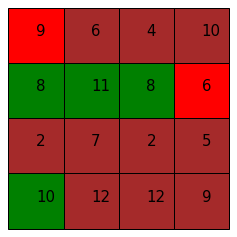

In [31]:
from hittingtime import *
import numpy as np
from catan import Catan, CatanException, get_random_dice_arrangement, Player, simulate_game, simulate_game_and_save
import matplotlib.pyplot as plt
from itertools import repeat
%matplotlib inline

available_locations_roads = []
# building = None
# x1,y1 = 0

costs = np.array([[2, 1, 1],
                  [1, 2, 2],
                  [0, 3, 3],
                  [1, 1, 0]])

num_trials = 1

width, height = 4, 4
dice = get_random_dice_arrangement(width, height)
resources = np.random.randint(0, 3, (height, width))
board = Catan(dice, resources)
board.draw()

turn: 27
points: 4
dice roll: 8
resources: [ 0.  0.  6.]
Drawing...


<function __main__.draw>

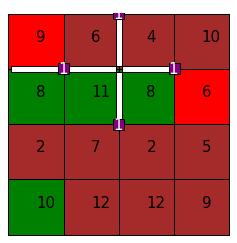

In [32]:
settlements, cities, roads, hands, live_points, dice_rolls = simulate_game_and_save(action, planBoard, board)

def draw(t):
    t = int(t)
    live_board = Catan(board.dice, board.resources, [], [])
    live_board.settlements = settlements[t]
    live_board.cities = cities[t]
    live_board.roads = roads[t]
    print("turn:", t)
    print("points:", live_points[t])
    print("dice roll:", dice_rolls[t])
    print("resources:", hands[t])
    live_board.draw()

from ipywidgets import *
interact(draw, t=(0, len(live_points) - 1, 1))

In [33]:
print(cities)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [ ]:
get_shortest_path_to_location([(0,0), (0,2)], 4,4)